In [1]:
# The code was removed by Watson Studio for sharing.

# Notebook for testing performance of intent classification in Watson Assistant Service
**[Watson Developer Cloud](https://www.ibm.com/watson/developer/)** is a platform of cognitive services that leverage machine learning techniques to help partners and clients solve a variety business problems. Furthermore, several of the WDC services fall under the **supervised learning** suite of machine learning algorithms, that is, algorithms that learn by example. This begs the questions: "How many examples should we provide?" and "When is my solution ready for prime time?"

It is critical to understand that training a machine learning solution is an iterative process where it is important to continually improve the solution by providing new examples and measuring the performance of the trained solution. In this notebook, we show how you can compute important Machine Learning metrics (accuracy, precision, recall, confusion_matrix) to judge the performance of your Watson Conversation service solution. For more details on these various metrics, please consult the **[Is Your Chatbot Ready for Prime-Time?](https://developer.ibm.com/dwblog/2016/chatbot-cognitive-performance-metrics-accuracy-precision-recall-confusion-matrix/)** blog.

You may also want to view some advice on best practices for Watson Assistant application development.  You can find these in **[Conversational Assistants and Quality with Watson Assistant](https://dtoczala.wordpress.com/2019/07/30/conversational-assistants-and-quality-with-watson-assistant/)**.  We also really liked [How to Design the Training Data for an AI Assitant]**(https://medium.com/ibm-watson/announcing-dialog-skill-analysis-for-watson-assistant-83cdfb968178)** and have imported a lot of their utility code (because we really like it).

# NOTE:  
This notebook was initially based upon a Python notebook provided by Joe Kozhaya, in his Watson Developer Cloud project on Github called [wdcutils](https://github.com/joe4k/wdcutils/).  We also have "borrowed" some code from the excellent work shared in this blog post on [How to Design the Training Data for an AI Assitant](https://medium.com/ibm-watson/announcing-dialog-skill-analysis-for-watson-assistant-83cdfb968178).  

Further work to bring the code "up to date", and to extend some of the concepts, was done by the folowing contributors:
- D. Toczala (dtoczala@us.ibm.com)

The notebook assumes you have already created a **[Watson Assistant](https://cloud.ibm.com/catalog/services/watson-assistant)** service instance and trained a skill within it based on a number of intents. You will also need a Cloud Object Storage (COS) in stance with a single bucket for storing results of the k-fold testing.</br>
<br> To leverage this notebook, you need to provide the following information:</br>

* Credentials for your Watson Conversation instance 
* Credentials for your Cloud Object Storage (COS)


# Table of contents

0. [Part 0: Prepare](#part0)<br>
    0.1 [Preparation](#part0.1)<br>
    0.2 [Credentials](#part0.2)<br>
    0.3 [Setup Cloud Object Storage (COS)](#part0.3)<br>
    0.4 [Set Constants and Configuration Variables](#part0.4)<br>
    0.5 [Declare Watson Assistant V1 routines](#part0.5)<br>
1. [Part 1: Process Training Data](#part1)<br>
    1.1 [Get current workspace and an Assistant instance](#part1.1)<br>
    1.2 [Basic Utterance, Intent, Entity Processing](#part1.2)<br>
    1.3 [Analyze Class Imbalance](#part1.3)<br>
    1.4 [Distribution of Training Data](#part1.4)<br>
    1.5 [Perform Correlation Analysis](#part1.5)<br>
    1.6 [Visualize Terms Using a Heat Map](#part1.6)<br>
    1.7 [Ambiguity in the Training Data](#part1.7)<br>
2. [Part 2: Process Testing Data](#part2)<br>
    2.1 [Break Data Into 5 K-fold Training/Testing Sets](#part2.1)<br>
    2.2 [Loop Through Each Test "Fold"](#part2.2)<br>
    2.3 [Build Confusion Matrix](#part2.3)<br>
    2.4 [Analyze the Errors](#part2.4)<br>
3. [Part 3: Advanced Analysis](#part3)<br>
    3.1 [Perform Analysis Using Confidence Thresholds](#part3.1)<br>
    3.2 [Analysis Interpretation at Confidence Level T](#part3.2)<br>
    3.3 [Analyze Abnormal Confidence Levels](#part3.3)<br>
    3.4 [Perform an Analysis Using Correlated Entities per Intent](#part3.4)<br>
    3.5 [Calculate Base Chatbot Scores](#part3.5)<br>
4. [Part 4: Summary](#part4)<br>


<a id='part0'></a>
# Part 0: Prepare
0.1 [Preparation](#part0.1)<br>
0.2 [Credentials](#part0.2)<br>
0.3 [Setup Cloud Object Storage (COS)](#part0.3)<br>
0.4 [Set Constants and Configuration Variables](#part0.4)<br>
0.5 [Declare Watson Assistant V1 routines](#part0.5)<br>

<a id='part0.1'></a>
## 0.1 - Preparation

Install and bring in all of the packages and code that you will need

In [2]:
# Filter out any warnings
from IPython.display import Markdown, display, HTML
import warnings
warnings.filterwarnings('ignore')
#
# Go and download the non-standard packages that you need
# Note: We use the assistant-dialog-skill-analysis package - but if they go in a different direction
#       we might need to fork and just use the code that we need.
#
!pip install --index-url https://pypi.python.org/simple  -U "pip"
!pip install --index-url https://pypi.python.org/simple  -U "assistant-dialog-skill-analysis>=1.1.0"
!pip install ibm-watson
!pip install pandas_ml
#
# We used to use pandas_ml for some processing - but it got to be out of date
#
#!pip install pandas_ml
#
# Standard Python libraries
#
import sys, os
import json
import importlib
import types
from collections import Counter
import codecs
import re
import time
from os.path import join, dirname
from datetime import datetime
import unicodecsv as csv

#
# Grab your data manipulation libraries
#
import pandas as pd
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('punkt')
#
# grab your display helpers
#
import seaborn as sn

#
# We used to use pandas_ml for some processing - but it got to be out of date
# sklearn and matplotlib were also used by the original version - but are no longer needed
#
#import pandas_ml
#from pandas_ml import ConfusionMatrix
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import precision_recall_fscore_support
#from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score
#import matplotlib.pyplot as plt

#
# IBM Watson and IBM Cloud libraries and SDKs
#
import ibm_watson
from ibm_watson import ApiException
from ibm_watson import AssistantV1
from ibm_watson import AssistantV2
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator
from botocore.client import Config
import ibm_boto3

#
# Grab that Watson Assistant Skill Analysis library
#
from assistant_dialog_skill_analysis.utils import skills_util
from assistant_dialog_skill_analysis.highlighting import highlighter
from assistant_dialog_skill_analysis.data_analysis import summary_generator
from assistant_dialog_skill_analysis.data_analysis import divergence_analyzer
from assistant_dialog_skill_analysis.data_analysis import similarity_analyzer
from assistant_dialog_skill_analysis.term_analysis import chi2_analyzer
from assistant_dialog_skill_analysis.term_analysis import keyword_analyzer
from assistant_dialog_skill_analysis.term_analysis import entity_analyzer
from assistant_dialog_skill_analysis.confidence_analysis import confidence_analyzer
from assistant_dialog_skill_analysis.inferencing import inferencer
from assistant_dialog_skill_analysis.experimentation import data_manipulator


Looking in indexes: https://pypi.python.org/simple
Requirement already up-to-date: pip in /opt/conda/envs/Python36/lib/python3.6/site-packages (20.0.2)
Looking in indexes: https://pypi.python.org/simple
Requirement already up-to-date: assistant-dialog-skill-analysis>=1.1.0 in /opt/conda/envs/Python36/lib/python3.6/site-packages (1.1.0)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/dsxuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/dsxuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<a id='part0.2'></a>
## 0.2 - Credentials
Provide the credentials to access your Conversation service and a COS storage bucket.

In [3]:
credentials = {
#
# Cloud Object Storage (COS) and IAM Parameters
#
#    'USE_COS' : can be either 'True', if using COS to store results, or 'False' if not using COS
#    'IAM_SERVICE_ID': the IAM service ID - you can find this on the "Service Credentials" tab, just
#                      select the service key and click on the "View Credentials" caret, and in the
#                      JSON that is shown, choose the "iam_serviceid_crn" field,
#    'IBM_API_KEY_ID': the IAM service ID - you can find this on the "Service Credentials" tab, just
#                      select the service key and click on the "View Credentials" caret, and in the
#                      JSON that is shown, choose the "apikey" field,
#    'ENDPOINT': your API endpoint.  Check the endpoints specified in COS, for your specific region, 
#                which can be found at https://cloud.ibm.com/docs/services/cloud-object-storage?topic=cloud-object-storage-endpoints
#    'IBM_AUTH_ENDPOINT': the IBM Authentiocation endpoint - https://iam.bluemix.net/oidc/token,
#    'RESULTS_BUCKET': Plain text name of the COS bucket for your results,
#    'BUCKET': Plain text name of the COS bucket you are accessing for credential information
#
    'USE_COS' : 'True',
    'IAM_SERVICE_ID': 'crn:v1:bluemix:public:iam-identity::a/d50fb47sjewy36597f8f2efdwe53eeds5::serviceid:ServiceId-2beye65f-2ww9-4226-beef-7363eds5233a',
    'IBM_API_KEY_ID': '84823hyrTH62UY762dlf7wmrPkZrh12eytey346dejqw7HW5N',
    'ENDPOINT': 'https://s3.us-south.cloud-object-storage.appdomain.cloud',
    'IBM_AUTH_ENDPOINT': 'https://iam.bluemix.net/oidc/token',
    'BUCKET': 'my-bucket',
#
# Assistant creds
#
#    'ASSISTANT_API_KEY': the API key for your Watson Assistant instance,
#    'ASSISTANT_VERSION': the version of the Watson Assistant API being used, generally something like '2019-02-28',
#    'ASSISTANT_URL': path to the service URL, generally this is 'https://gateway.watsonplatform.net/assistant/api',
#    'ASSISTANT_SKILL_ID': ID of the skill being worked on and tested
#
    'ASSISTANT_API_KEY': 'xxx999999999863Eshsyetd3GFotx4pBtoxtoxwesd6x',
    'ASSISTANT_VERSION': '2019-02-28',
    'ASSISTANT_URL': 'https://gateway.watsonplatform.net/assistant/api',
    'ASSISTANT_SKILL_ID': '2354west-45e4-4a23-8ac1-e6187ert5w45'
#
# Note that the ASSISTANT SKILL ID is tricky to get.
#
# In order to get this, go into Watson Assistant and look at the Skills viewer.  For the skill that you want to use, 
# click on the three dots in the upper right corner, and select "View API Details".  On the ensuing page, look at the
# credentials at the top of the page, and find the one that looks like this:
#
# Legacy v1 Workspace URL:https://gateway.watsonplatform.net/assistant/api/v1/workspaces/2354west-45e4-4a23-8ac1-e6187ert5w45/message
#
# Note that the ASSISTANT SKILL ID is actually the V1 Workspace ID, which is the second to last part of the path in 
# the example above (2354west-45e4-4a23-8ac1-e6187ert5w45).  This is the unique identifier for the workspace.
}

#######################################################
#
# CONSTANTS 
#
MAX_TERMS_DISPLAY = 30                # Total number of terms to display in various outputs
#
INTENTS_TO_DISPLAY = 30               # Total number of intents for display
#
USE_COS = credentials['USE_COS']      # Will you be using Cloud Object Storage to store results?
#
THREAD_NUM = 3                        # Maximum number of concurrent threads to use at any one time
#
#######################################################
#
# VARIABLES
#
# These variables and lists should be user entered and will differ for each individual Watson Assistant instance.
# As you use this to test your model over time, you will want to focus analysis on certain problem areas.  These
# variables and list highlight those areas to focus on.
#
# Later in the code we have a way to analyze specific intents in more depth.
# Add the names of those intents to this list to force that analysis.
#
# For example: focused_intent_list = [greeting, transaction, customer_support]
#
focused_intent_list = []
#
# Later in the code we have a way to compare specific intents in more depth for overlap.
# Add the names of those intents to this list to force that analysis.
#
# For example: 
#    overlap_intent_1 = 'transaction'
#    overlap_intent_2 = 'customer_support'
#
overlap_intent_1 = ''
overlap_intent_2 = ''

In [4]:
# The code was removed by Watson Studio for sharing.

<a id='part0.3'></a>
## 0.3 - Setup Cloud Object Storage (COS)

Create your COS object and get it all setup

In [5]:
#
DEBUG=False
#DEBUG=True
#
# Grab creds file from COS storage
#
# IBM COS interface
if USE_COS:
    def __iter__(self): return 0
    from ibm_botocore.client import Config

    cos = ibm_boto3.client(service_name='s3',
        ibm_api_key_id=credentials['IBM_API_KEY_ID'],
        ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
        ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
        config=Config(signature_version='oauth'),
        endpoint_url=credentials['ENDPOINT'])
#
# Build filenames that you will use
#
UNDERSCORE = '_'
#
# First get current date/time
#
myDatetime = datetime.now()
if (DEBUG):
    print (myDatetime)
myDatetime = re.sub(r'\s',UNDERSCORE,str(myDatetime))
goodDatetime,junk = myDatetime.split('.')
#
# Build filenames
#
# Watson Assistant workspace definition (model)
#
Workspace_file = 'Backup_Assistant_Workspace_'+goodDatetime+'.json'
Workspace_path = './'+ Workspace_file
#
# K-Fold test results
#
TestResults_file = 'KFold_Results_'+goodDatetime+'.csv'
TestResults_path = './'+ TestResults_file
#
# K-Fold test results
#
Scores_file = 'KFold_Scores_'+goodDatetime+'.csv'
Scores_path = './'+ Scores_file
#

<a id='part0.4'></a>
## 0.4 - Set Constants and Configuration Variables

Set variables for those credentials and for accessing Watson services, COS buckets, and other resources.

In [6]:
#
# Set all required parameters
# 
assist_api_key=credentials['ASSISTANT_API_KEY']
wa_version=credentials['ASSISTANT_VERSION']
wa_url=credentials['ASSISTANT_URL']
assist_workspace_id=credentials['ASSISTANT_SKILL_ID']
#
# Change URL based on IBM Cloud datacenter you use 
#
URL = credentials['ASSISTANT_URL']

<a id='part0.5'></a>
## 0.5 - Declare Watson Assistant V1 routines
Define useful methods to classify using trained Watson Assistant service.

In [7]:
#
# Given a pointer to an Assistamt instance and a workspace ID, go and delete a workspace, get back status
#
def deleteAssistantWorkspace(assist_instance,workspaceID):
    context={}
    MAX_ATTEMPTS = 2
    tries = 0
    need_results = True
    while (need_results and (tries < MAX_ATTEMPTS)):
        try:
            response = assist_instance.delete_workspace(
                workspace_id=workspaceID)
            need_results = False
        except Exception as e:
            print("will retry after error", e)
            tries += 1
            time.sleep(5)
        # end of loop to retry

    if tries < MAX_ATTEMPTS:
        workspaceStatus=response.get_result()
        
    return workspaceStatus

#
# Given a pointer to an Assistamt instance and workspaceID, get back Assistantkeep checking the workspace
# and don't return until workspace is "Available" - return true if workspace is available, false if timeout
# reached 
#
def waitAssistantWorkspace(assist_instance,workspaceID,timeout):
    stat=False
    MAX_ATTEMPTS = int (timeout // 5)
    tries = 0
    while (stat == False) and (tries < MAX_ATTEMPTS):
        try:
            response = assist_instance.get_workspace(
                workspace_id=workspaceID)
        except:
            tries += 1
            time.sleep(5)
            sys.stdout.write('.')
            continue
        #
        # Now check the status
        #
        settings = response.get_result()
        if (settings['status'] == "Available"):
            stat=True
            break
        else:
            tries += 1
            time.sleep(5)
            sys.stdout.write('.')
        # end of loop to retry 
    return stat

#
# Taking a Watson Assistant workspace JSON object, break the intents and training data
# into a series of "k-folds", based on the percentages given.  So for a k=5 k-fold test, 
# we would call this 5 times, with start/end values of 0/20, 20/40, 40/60, 60/80, and 80/100.
# For a k=3 k-fold test, we would call this 3 times, with start/end values of 0/33, 34/66, 
# and 67/100.
# 

def kfold_sampling(workspace, slice_start_pct=0.0, slice_end_pct=0.2):
    """
    Create a stratified sample of the workspace json
    & return a intent json acceptable in Assistant API
    :param workspace: json format output defined by Assistant API
    :param sampling_percentage: percentage of original to sample
    :return train_workspace_data: list of intents for train
    :return test_workspace_data: list of utterance,intent pairs for test
    """
    train_workspace_data = list()
    test_workspace_data = list()
    for i in range(len(workspace["intents"])):
        intent = workspace["intents"][i]
        sampling_index = list(np.arange(len(intent["examples"])))
        # training set
        train_test_split_start = int(slice_start_pct * len(sampling_index))
        train_test_split_cutoff = int(slice_end_pct * len(sampling_index))
        train_examples_1 = [
            intent["examples"][index]
            for index in sampling_index[0:train_test_split_start]
        ]
        train_examples_2 = [
            intent["examples"][index]
            for index in sampling_index[train_test_split_cutoff:]
        ]
        train_examples = train_examples_1 + train_examples_2
        train_workspace_data.append({"intent": workspace["intents"][i]["intent"]})
        train_workspace_data[i].update({"description": "string"})
        train_workspace_data[i].update({"examples": train_examples})
        # test set
        test_examples = [
            intent["examples"][index]
            for index in sampling_index[train_test_split_start:train_test_split_cutoff]
        ]
        #
        test_example_data = [
            {'utterance': utterances["text"], 'intent': workspace["intents"][i]["intent"]}
            for utterances in test_examples
            ]
        test_workspace_data.extend(test_example_data)
        #
        # Convert to a data frame
        #
        test_workspace_df = pd.DataFrame(test_workspace_data)
        
    return train_workspace_data, test_workspace_df

#
# Taking a Watson Assistant object, create a new workspace and apply the training data given.
# Then apply the test set provided, and collect results.  Delete the workspace, and return
# the test results.
# 
def processKFold (assist_instance,training_json,test_df):
    #
    # Create workspace, and save workspace ID
    #
    print("Begin test run ")
    testAssistWorkspace=skills_util.create_workspace(assist_instance, intent_json=training_json)
    testWorkspaceID = testAssistWorkspace["workspace_id"]
    #
    # Wait for training to complete
    #
    # print("Created first fold test environment ")
    stat = waitAssistantWorkspace(assist_instance,testWorkspaceID,600) # 600 second timeout for training (ten minutes)
    #
    # Run your tests - note we suggest a maximum of 5 threads for faster inference
    #
    full_results = inferencer.inference(assist_instance,
                                        testWorkspaceID,
                                        test_df,
                                        max_retries=10,
                                        max_thread=THREAD_NUM, 
                                        verbose=False)
    #
    # Delete the test workspace
    #
    stat = deleteAssistantWorkspace(assist_instance,testWorkspaceID)
    #
    return full_results


<a id='part1'></a>
# Part 1: Process Training Data
1.1 [Get current workspace and an Assistant instance](#part1.1)<br>
1.2 [Basic Utterance, Intent, Entity Processing](#part1.2)<br>
1.3 [Analyze Class Imbalance](#part1.3)<br>
1.4 [Distribution of Training Data](#part1.4)<br>
1.5 [Perform Correlation Analysis](#part1.5)<br>
1.6 [Visualize Terms Using a Heat Map](#part1.6)<br>
1.7 [Ambiguity in the Training Data](#part1.7)<br>

<a id='part1.1'></a>
## 1.1 - Get current workspace and an Assistant instance

We want to get a copy of the current workspace, which we will manipulate for testing purposes, as well as an object for the Watson Assistant instance.

In [8]:
importlib.reload(skills_util)
#
#
#
conversation, workspace = skills_util.retrieve_workspace(iam_apikey=assist_api_key,
                                                         workspace_id=assist_workspace_id,
                                                         url=URL,
                                                         api_version=wa_version)

#
# If COS is enabled, save your Workspace off
#
if USE_COS:
    with open(Workspace_file, 'w') as fp:
        json.dump(workspace, fp)
    fp.close()
    #
    # Write Assistant settings out to COS
    #
    cos.upload_file(Filename=Workspace_path,Bucket=credentials['BUCKET'],Key=Workspace_file)
    #
    print ("Workspace saved off to file " + Workspace_file + " in results area.")
#

Workspace saved off to file Backup_Assistant_Workspace_2020-02-11_15:07:36.json in results area.


<a id='part1.2'></a>
## 1.2 Basic Utterance, Intent, Entity Processing

Generate summary statistics related to the given skill and workspace.

In [9]:
#
# Extract user workspace data and vocabulary
#
workspace_data, workspace_vocabulary = skills_util.extract_workspace_data(workspace)
#
# Build a dictionary of entities and an entity list
#
entity_dict = conversation.list_entities(assist_workspace_id).get_result()
entities_list = [item['entity'] for item in entity_dict['entities']]
#
# Create a workspace data frame from Workspace data
#
workspace_pd = pd.DataFrame(workspace_data)
#
# Dump sample (first 10) of utterances and intents
#
display(Markdown("### Sample of Utterances & Intents"))
display(HTML(workspace_pd.sample(n = len(workspace_pd) if len(workspace_pd)<10 else 10)
             .to_html(index=False)))
#
# Dump sample (first 10) of entities, if there are any
#
if entities_list:
    display(Markdown("### Sample of Entities"))
    display(HTML(pd.DataFrame({"Entity":entities_list})
                 .sample(n = len(entities_list) if len(entities_list)<10 else 10)
                 .to_html(index=False)))
#
# Dump summary data
#
importlib.reload(summary_generator)
summary_generator.generate_summary_statistics(workspace_data, entities_list)

### Sample of Utterances & Intents

utterance,intent
client team,person_account_owner
Where can I find information about non-disclos...,site_help
who is our deal maker?,person_support
how much does each support level cost?,plan_info
assistant plus,site_help
line item hold,plan_info
i'd like to learn more about how to get starte...,site_help_training
Who can I go to for quoting questions?,person_support
OM for stt?,person_om
where can i learn how to build a watson assist...,site_help_training


### Sample of Entities

Entity
vmware
openscale
invoice
discovery
asp-net
text-to-speech
CEC
speech-to-text
sys-person
support


### Summary Statistics

,Data Characteristic,Value
1,Total User Examples,215
2,Unique Intents,14
3,Average User Examples per Intent,15
4,Standard Deviation from Average,14
5,Total Number of Entities,91


<a id='part1.3'></a>
## 1.3 - Analyze Class Imbalance

Analyze whether the data set contains class imbalance by checking whether the largest intent contains less than double the number of user examples contained in the smallest intent. If there is an imbalance it does not necessarily indicate an issue; but you should review the [actions](#actionimbalance) section below.

In [10]:
importlib.reload(summary_generator)
class_imb_flag = summary_generator.class_imbalance_analysis(workspace_pd)

### <font style='color:rgb(165, 34, 34);'> Class Imbalance Detected         </font>

- Data could be potentially biased towards intents with more user         examples

- E.g. Intent < site_help > has < 56 > user examples while intent < feedback > has         just < 2 > user examples 

### Actions for class imbalance<a id='actionimbalance'></a>

Class imbalance will not always lead to lower accuracy, which means that all intents (classes) do not need to have the same number of examples.

Given a hypothetical chatbot related to banking:<br>

- For intents like `updateBankAccount` and `addNewAccountHolder` where the semantics difference between them is subtler, the number of examples per intent needs to be somewhat balanced otherwise the classifier might favor the intent with the higher number of examples.
- For intents like `greetings` that are semantically distinct from other intents like `updateBankAccount`, it may be acceptable for it to have fewer examples per intent and still be easy for the intent detector to classify.

If the intent classification accuracy is lower than expected during testing, you should re-examine the distribution analysis.  

With regard to sorted distribution of examples per intent, if the sorted number of user examples varies a lot across different intents, it can be a potential source of bias for intent detection. Large imbalances in general should be avoided. This can potentially lead to lower accuracy. If your graph displays this characteristic, this could be a source of error.

For further guidance on adding more examples to help balance out your distribution, refer to 
<a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intent-recommendations#intent-recommendations-get-example-recommendations" target="_blank" rel="noopener no referrer">Intent Example Recommendation</a>.

<a id='part1.4'></a>
## 1.4 - Distribution of Training Data
Display the distribution of intents versus the number of examples per intent (sorted by the number of examples per intent) below. Ideally you should not have large variations in terms of number of user examples for various intents. 

In [11]:
#
# Build and display plot of intent distribution
#
#importlib.reload(summary_generator)
#summary_generator.scatter_plot_intent_dist(workspace_pd)
#
# Build and display list of intent distribution
#
importlib.reload(summary_generator)
summary_generator.show_user_examples_per_intent(workspace_data)

### Sorted Distribution of User Examples per Intent

,Intent,Number of User Examples
1,feedback,2
2,tech_help,4
3,readme,4
4,insult,7
5,anything_else,7
6,general_thanks,9
7,general_greeting,10
8,person_support,11
9,person_account_owner,14
10,person_csm,14


### You MUST HAVE TEN OR MORE EXAMPLES for each intent!!

We are going to do a k-fold analysis of the training data, and in order for this to work correctly and the data to be accurate, we need to have at least two examples in each "fold" of the k-fold groups. Since we are doing this with k=5 (five folds of your data), you need to <b>have at least 10 examples for each intent</b>.

It's also considered a <b>Watson Assistant Best Practice</b> to have at least 10 utterances/examples for each intent.  

<a id='part1.5'></a>
## 1.5 - Perform Correlation Analysis

- [Retrieve the most correlated unigrams and bigrams for each intent](#retrieve)
- [Actions for anomalous correlations](#anomalous)

### Retrieve the most correlated unigrams and bigrams for each intent<a id='retrieve'></a>

Perform a chi square significance test using count features to determine the terms that are most correlated with each intent in the data set. 

A `unigram` is a single word, while a `bigram` is two consecutive words from within the training data. For example, if you have a sentence like `Thank you for your service`, each of the words in the sentence are considered unigrams while terms like `Thank you`, `your service` are considered bigrams.

Terms such as `hi`, `hello` correlated with a `greeting` intent are reasonable. But terms such as `table`, `chair` correlated with the `greeting` intent are anomalous. A scan of the most correlated unigrams & bigrams for each intent can help you spot potential anomalies within your training data.

**Note**: We ignore the following common words (\"stop words\") from consideration `an, a, in, on, be, or, of, a, and, can, is, to, the, i`

In [12]:
importlib.reload(chi2_analyzer)
unigram_intent_dict, bigram_intent_dict = chi2_analyzer.get_chi2_analysis(workspace_pd)

## Chi-squared Analysis

,Intent,Correlated Unigrams,Correlated Bigrams
1,site_help,"my, about, information, find, where","my account, do see, find information, information about, where find"
2,plan_info,"cost, year, much, discount, subscription","discount we, different support, been applied, what are, how much"
3,person_om,"text, storage, who, for, om","compare comply, who are, for assistant, who om, om for"
4,site_help_training,"entity, assistant, link, learn, watson","want learn, link watson, watson discovery, how link, watson assistant"
5,person_csm,"machine, learning, with, help, technical","who help, machine learning, technical help, need technical, help with"
6,person_account_owner,"user, if, account, owner, am","accounts how, how tell, am account, if am, account owner"
7,person_support,"invoices, no, quoting, deal, maker","quoting questions, do track, about softlayer, who go, deal maker"
8,general_greeting,"wassup, howdy, hey, busy, hello","you there, hello csm, csm bot, you busy, are you"
9,general_thanks,"u, very, nice, thanks, thank","nice job, nice thanks, thank u, very nice, thank you"
10,anything_else,"general_greeting, cloudflare, connect, endpoint, ceo","available ibm, ceo ibm, connect available, do implement, who ceo"


### Actions for anomalous correlations<a id='anomalous'></a>

If you identify unusual or anomalous correlated terms such as: numbers, names and so on, which should not be correlated with an intent, consider the following:
  
- **Case 1** : If you see names appearing amongst correlated unigrams or bigrams, add more variation of names so no specific names will be correlated  
- **Case 2** : If you see specific numbers like 1234 amongst correlated unigrams or bigrams and these are not helpful to the use case, remove or mask these numbers from the examples
- **Case 3** : If you see terms which should never be correlated to that specific intent, consider adding or removing terms/examples so that domain specific terms are correlated with the correct intent

<a id='part1.6'></a>
## 1.6 - Visualize Terms Using a Heat Map

- [Display term analysis for a custom intent list](#customintent)
- [Actions for anomalous terms in the heat map](#heatmap)

A heat map of terms is a method to visualize terms or words that frequently occur within each intent. Rows are the terms, and columns are the intents. 

The code below displays the top 30 intents with the highest number of user examples in the analysis. This number can be changed if needed.

## <p style="text-align: center;"> Token Frequency per Intent </p>

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


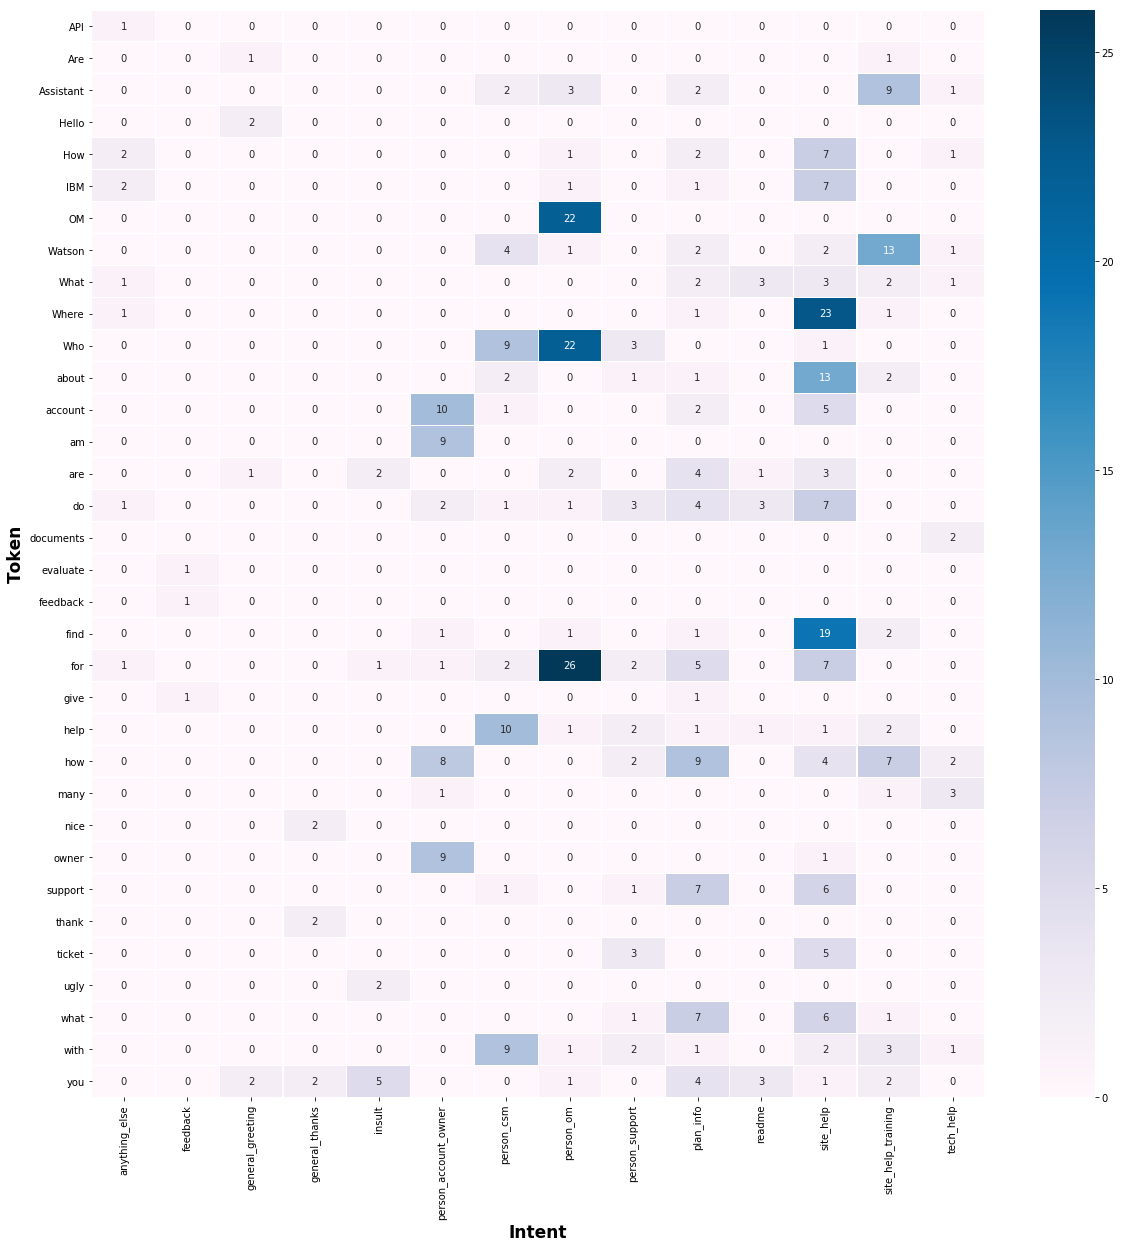

In [13]:
importlib.reload(keyword_analyzer)
intent_list = []
keyword_analyzer.seaborn_heatmap(workspace_pd, INTENTS_TO_DISPLAY, MAX_TERMS_DISPLAY, intent_list)

### Display term analysis for a custom intent list<a id='customintent'></a>

If you wish to see term analysis for specific intents, feel free to add those intents to the intent list. This generates a custom term heatmap. The code below displays the top 20 terms, but this can be changed if needed.

## <p style="text-align: center;"> Token Frequency per Intent </p>

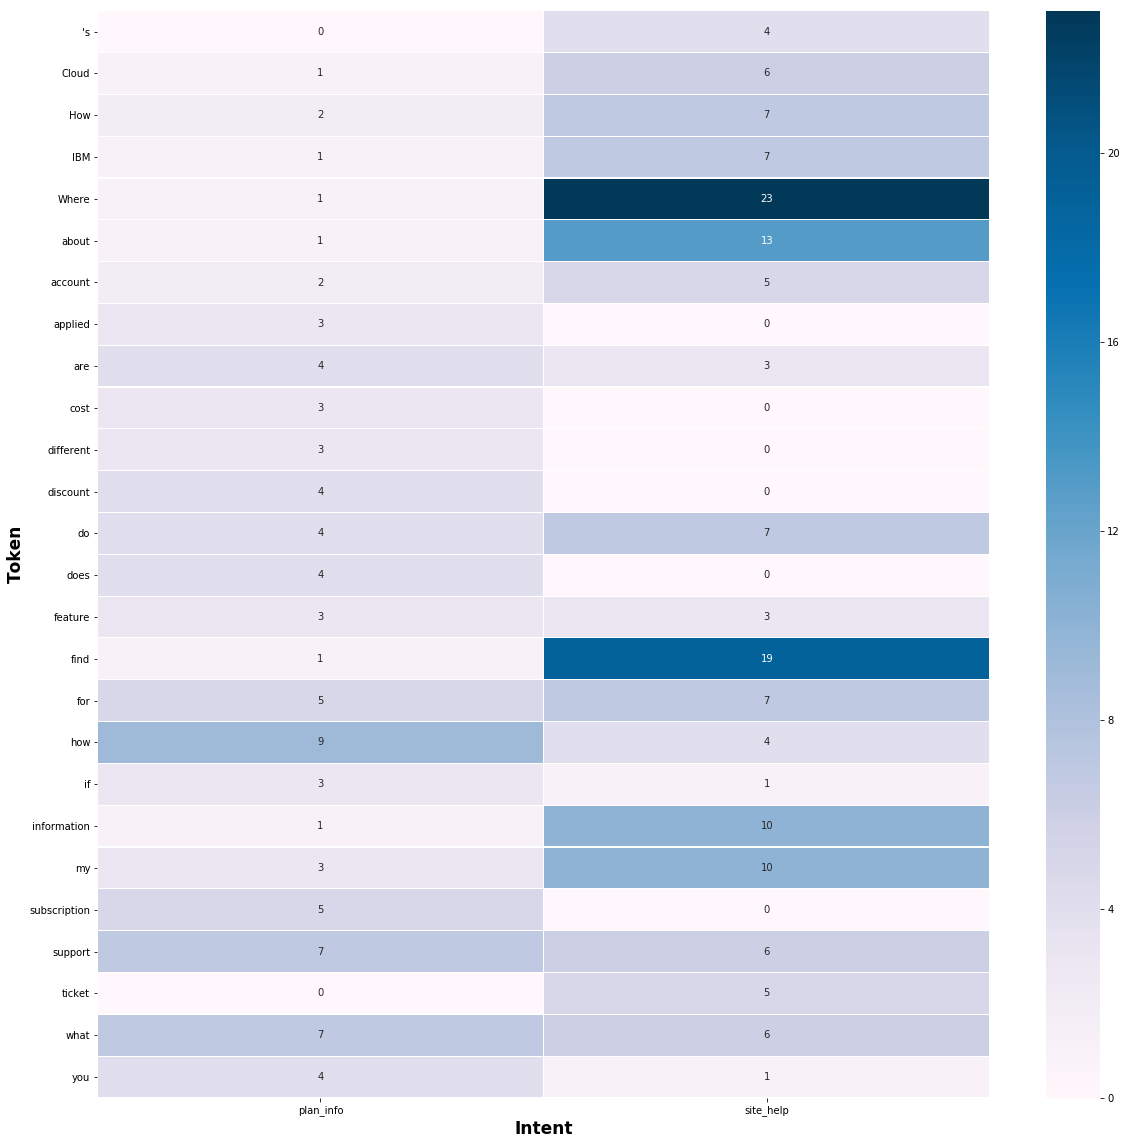

In [14]:
importlib.reload(keyword_analyzer)
# focused_intent_list = ['intent_a', 'intent_b']   # set in section 0.2
intent_list = focused_intent_list

if intent_list: 
    keyword_analyzer.seaborn_heatmap(workspace_pd, INTENTS_TO_DISPLAY, MAX_TERMS_DISPLAY, intent_list)

### Actions for anomalous terms in the heat map<a id='heatmap'></a>

If you notice any terms or words which should not be frequently present within an intent, consider modifying examples in that intent.

<a id='part1.7'></a>
## 1.7 - Ambiguity in the Training Data

- [Uncover ambiguous utterances across intents](#uncover)
- [Actions for ambiguity in the training data](#ambiguityaction)

Run the code blocks below to uncover possibly ambiguous terms based on feature correlation.

Based on the chi-square analysis above, generate intent pairs which have overlapping correlated unigrams and bigrams.
This allows you to get a glimpse of which unigrams or bigrams might cause potential confusion with intent detection:

#### Top Intent Pairs with Overlapping Correlated Unigrams

In [15]:
importlib.reload(chi2_analyzer)
display(Markdown("### Top Intent Pairs with Overlapping Correlated Unigrams"))
ambiguous_unigram_df = chi2_analyzer.get_confusing_key_terms(unigram_intent_dict)

### Top Intent Pairs with Overlapping Correlated Unigrams

Intent Pairs,Terms
"<insult, readme>",you
"<insult, readme>",your


#### Top Intent Pairs with Overlapping Correlated Bigrams

In [16]:
importlib.reload(chi2_analyzer)
display(Markdown("### Top Intent Pairs with Overlapping Correlated Bigrams"))
ambiguous_bigram_df = chi2_analyzer.get_confusing_key_terms(bigram_intent_dict)

### Top Intent Pairs with Overlapping Correlated Bigrams

There is no ambiguity based on top 5 key terms in chi2 analysis

#### Overlap Checker for Specific Intents

In [17]:
# Add specific intent or intent pairs for which you would like to see overlap
importlib.reload(chi2_analyzer)
# overlap_intent_1 = 'intent1'  # this is set in section 0.2
# overlap_intent_2 = 'intent2'  # this is set in section 0.2
display(Markdown("### Potential Term Overlap in Intent Training Data"))
chi2_analyzer.chi2_overlap_check(ambiguous_unigram_df,ambiguous_bigram_df,overlap_intent_1,overlap_intent_2)

### Potential Term Overlap in Intent Training Data

Intent Pairs,Terms


### Uncover ambiguous utterances across intents<a id='uncover'></a>
The following analysis shows user examples that are similar but fall under different intents.  

In [18]:
importlib.reload(similarity_analyzer)
display(Markdown("### Ambiguous Utterances in Training Data"))
similar_utterance_diff_intent_pd = similarity_analyzer.ambiguous_examples_analysis(workspace_pd)


### Ambiguous Utterances in Training Data

Intent1,Utterance1,Intent2,Utterance2,similarity score
person_csm,Who can I go to for Discovery questions?,person_support,Who can I go to for quoting questions?,0.769231
person_csm,Who can I go to for Discovery questions?,person_support,Who can I go to for SQO questions?,0.769231
person_csm,Who can help me with invoice issues?,person_support,who can help me with Gaia?,0.752618
person_csm,Who can help me with invoice issues?,person_support,Who can help me with SQO?,0.752618
person_csm,Who can help me with Watson Assistant,person_support,who can help me with Gaia?,0.752618
person_csm,Who can help me with Watson Assistant,person_support,Who can help me with SQO?,0.752618
person_support,who can help me with Gaia?,person_om,who can help me with compare comply?,0.752618
person_support,Who can help me with SQO?,person_om,who can help me with compare comply?,0.752618
plan_info,Where can I find information about IBM Cloud subscription discounts?,site_help,Where can I find information about the IBM Cloud roadmap?,0.705882


### Actions for ambiguity in the training data<a id='ambiguityaction'></a>

**Ambiguous intent pairs**  
If you see terms which are correlated with more than 1 intent, review if this seems anomalous based on the use case for that intent. If it seems reasonable, it is probably not an issue.  

**Ambiguous utterances across intents** 
- **Duplicate utterances**: For duplicate or almost identical utterances, remove those that seem unnecessary.
- **Similar utterances**: For similar utterances, review the use case for those intents and make sure that they are not accidental additions caused by human error when the training data was created.  

For more information about entity, refer to the <a href="https://cloud.ibm.com/docs/services/assistant/services/assistant?topic=assistant-entities" target="_blank" rel="noopener no referrer">Entity Documentation</a>.

For more in-depth analysis related to possible conflicts in your training data across intents, try the conflict detection feature in Watson Assistant. Refer to <br> <a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intents#intents-resolve-conflicts" target="_blank" rel="noopener no referrer">Conflict Resolution Documentation</a>.

In [19]:
#
#  This block is just a DEBUG block
# I use it to help visualize what the various JSON, lists, and data frames look like
#
DEBUG=False
#DEBUG=True

if (DEBUG):
    print ("\n\n==========\n workspace_pd \n")
    print (workspace_pd)
    #
    tox_df = pd.DataFrame(workspace_data)
    print ("\n\n==========\n tox_df \n")
    print (tox_df)
    #
    tox_json = tox_df.to_json(orient='records')
    print ("\n\n==========\n tox_json \n")
    print (tox_json)
    #
    print ("\n\n==========\n workspace \n")
    print (workspace)

<a id='part2'></a>
# Part 2: Process Testing Data
2.1 [Break Data Into 5 K-fold Training/Testing Sets](#part2.1)<br>
2.2 [Loop Through Each Test "Fold"](#part2.2)<br>
2.3 [Build Confusion Matrix](#part2.3)<br>
2.4 [Analyze the Errors](#part2.4)<br>

<a id='part2.1'></a>
## 2.1 - Break Data Into 5 K-fold Training/Testing Sets

We want to take our copy of the current workspace, and th.en break it into 5 sets of training data and associated test data, each with a distribution of 20% of each intent for test data, and 80% of each intents for training data.  I could try to make this random, but I don't have the time today.  Instead, we will take the data for each intent, and break it into five pieces.  So you will see something like this:

**Intent A** -> split into 5 pieces, A1, A2, A3, A4, and A5.
**Intent B** -> split into 5 pieces: B1, B2, B3, B4, and B5.

**Training set 1** -> A2 + A3 + A4 + A5 + B2 + B3 + B4 + B5
**Test Set 1** -> A1 + B1

**Training set 2** -> A1 + A3 + A4 + A5 + B1 + B3 + B4 + B5
**Test set 2** -> A2 + B2

**Training set 3** -> A1 + A2 + A4 + A5 + B1 + B2 + B4 + B5
**Test set 3** -> A3 + B3

**Training set 4** -> A1 + A2 + A3 + A5 + B1 + B2 + B3 + B5
**Test set 4** -> A4 + B4

**Training set 5** -> A1 + A2 + A3 + A4 + B1 + B2 + B3 + B4
**Test set 5** -> A5 + B5

In [20]:
#DEBUG=True
DEBUG=False
#
(TrainSet1_json, TestSet1) = kfold_sampling(workspace,slice_start_pct=0.0, slice_end_pct=0.2) 
(TrainSet2_json, TestSet2) = kfold_sampling(workspace,slice_start_pct=0.2, slice_end_pct=0.4)
(TrainSet3_json, TestSet3) = kfold_sampling(workspace,slice_start_pct=0.4, slice_end_pct=0.6)
(TrainSet4_json, TestSet4) = kfold_sampling(workspace,slice_start_pct=0.6, slice_end_pct=0.8)
(TrainSet5_json, TestSet5) = kfold_sampling(workspace,slice_start_pct=0.8, slice_end_pct=1.0)
#
# Now see how you split things up
#
if (DEBUG):
    print('\n========\nTRAIN SET 1\n')
    print(TrainSet1_json)
    print('\n========\nTEST SET 1\n')
    print(TestSet1)
    #
    print('\n========\nTRAIN SET 2\n')
    print(TrainSet2_json)
    print('\n========\nTEST SET 2\n')
    print(TestSet2)
    #
    print('\n========\nTRAIN SET 3\n')
    print(TrainSet3_json)
    print('\n========\nTEST SET 3\n')
    print(TestSet3)
    #
    print('\n========\nTRAIN SET 4\n')
    print(TrainSet4_json)
    print('\n========\nTEST SET 4\n')
    print(TestSet4)
    #
    print('\n========\nTRAIN SET 5\n')
    print(TrainSet5_json)
    print('\n========\nTEST SET 5\n')
    print(TestSet5)
    #

<a id='part2.2'></a>
# 2.2 Loop Through Each Test "Fold"
This is hardcoded to do k-fold testing with a K value = 5 right now.

Steps done are as follows:
1. Create a test workspace and load in training data
2. Run tests with test data against test workspace
3. Collect results
4. Delete test workspace

In [21]:
# 
#DEBUG = True
DEBUG = False
#
# Process each fold
#
fold_1_results = processKFold (conversation,TrainSet1_json,TestSet1)
fold_2_results = processKFold (conversation,TrainSet2_json,TestSet2)
fold_3_results = processKFold (conversation,TrainSet3_json,TestSet3)
fold_4_results = processKFold (conversation,TrainSet4_json,TestSet4)
fold_5_results = processKFold (conversation,TrainSet5_json,TestSet5)
#
frames = [fold_1_results, fold_2_results, fold_3_results, fold_4_results, fold_5_results]
full_results = pd.concat(frames)
#
# Dump results to COS file if COS is enabled
#
#
# If COS is enabled, save your Workspace off
#
if USE_COS:
    full_results.to_csv(TestResults_file,header=True, index=False)
    #
    # Write Assistant settings out to COS
    #
    cos.upload_file(Filename=TestResults_path,Bucket=credentials['BUCKET'],Key=TestResults_file)
    #
    print ("Kfold test results saved off to file " + TestResults_file + " in results area.")
#
#
if (DEBUG):
    print (full_results)

Begin test run 
.............Starting Thread-1
Starting Thread-2
Starting Thread-3
Exiting Thread-1
Exiting Thread-3
Exiting Thread-2
--- Total time: 7.303615093231201 seconds ---
Begin test run 
.........Starting Thread-1
Starting Thread-2
Starting Thread-3
Exiting Thread-3
Exiting Thread-2
Exiting Thread-1
--- Total time: 9.052803754806519 seconds ---
Begin test run 
........Starting Thread-1
Starting Thread-2
Starting Thread-3
Exiting Thread-2
Exiting Thread-3
Exiting Thread-1
--- Total time: 8.689165592193604 seconds ---
Begin test run 
..........Starting Thread-1
Starting Thread-2
Starting Thread-3
Exiting Thread-2
Exiting Thread-1
Exiting Thread-3
--- Total time: 8.82301115989685 seconds ---
Begin test run 
...........Starting Thread-1
Starting Thread-2
Starting Thread-3
Exiting Thread-3
Exiting Thread-2
Exiting Thread-1
--- Total time: 9.609599113464355 seconds ---
Kfold test results saved off to file KFold_Results_2020-02-11_15:07:36.csv in results area.


<a id='part2.3'></a>
## 2.3 Build Confusion Matrix

### Confusion Matrix Heatmap

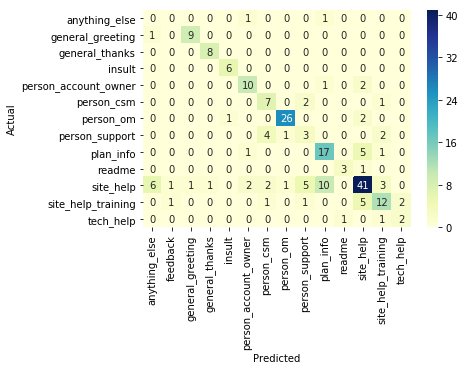

In [22]:
#
# Build lists for confusion matrix
#
AllTestClasses = full_results['top_intent'].to_list()
AllPredictClasses = full_results['correct_intent'].to_list()
#
# Build confusion matrix feed of actual and predicted intents
#
confMatrix_lists = {'Actual':AllTestClasses, 'Predicted':AllPredictClasses}
confMatrix_df = pd.DataFrame(confMatrix_lists, columns=['Actual','Predicted'])
#
# Build it into a data frame that you can feed to a heatmap
#
confusion_matrix = pd.crosstab(confMatrix_df['Actual'], confMatrix_df['Predicted'], rownames=['Actual'], colnames=['Predicted'])
#
# Print the heatmap
#
display(Markdown("### Confusion Matrix Heatmap"))
sn.heatmap(confusion_matrix, cmap="YlGnBu", annot=True)

<a id='part2.4'></a>
## 2.4 - Analyze the Errors

This section gives you an overview of the errors made by the intent classifier on the test set.  

**Note**: `System Out of Domain` labels are assigned to user examples which get classified with confidence scores less than 0.2 as Watson Assistant considers them to be irrelevant.

In [23]:
importlib.reload(inferencer)
wrongs_df = inferencer.calculate_mistakes(full_results)
display(Markdown("### Intent Detection Mistakes"))
display(Markdown("Number of Test Errors: {}".format(len(wrongs_df))))

with pd.option_context('max_colwidth', 250):
    if not wrongs_df.empty:
        display(wrongs_df)

### Intent Detection Mistakes

Number of Test Errors: 71

,correct_intent,entities,top_confidence,top_intent,top_predicts,utterance
Test Example Index,,,,,,
1,site_help_training,[],0.483891,person_support,"[{'intent': 'person_support', 'confidence': 0.4838908910751343}, {'intent': 'anything_else', 'confidence': 0.2927596986293793}, {'intent': 'plan_info', 'confidence': 0.2759956181049347}, {'intent': 'tech_help', 'confidence': 0.2626443982124329}, ...",What is gaia
2,site_help_training,[],0.511503,person_support,"[{'intent': 'person_support', 'confidence': 0.5115025281906128}, {'intent': 'insult', 'confidence': 0.3725476861000061}, {'intent': 'site_help', 'confidence': 0.3085211277008057}, {'intent': 'person_account_owner', 'confidence': 0.295689022541046...",gaia
4,anything_else,[],0.335742,site_help,"[{'intent': 'site_help', 'confidence': 0.3357422828674317}, {'intent': 'person_om', 'confidence': 0.31462762355804447}, {'intent': 'person_account_owner', 'confidence': 0.2705537557601929}, {'intent': 'insult', 'confidence': 0.252159982919693}, {...",who is the CEO of IBM?
5,person_csm,[],0.452855,site_help,"[{'intent': 'site_help', 'confidence': 0.4528554201126099}, {'intent': 'person_support', 'confidence': 0.3939491391181946}, {'intent': 'person_csm', 'confidence': 0.34977413415908815}, {'intent': 'insult', 'confidence': 0.23206841051578522}, {'in...",Who can help me with invoice issues?
15,person_support,[],0.758917,person_csm,"[{'intent': 'person_csm', 'confidence': 0.7589171886444093}, {'intent': 'site_help', 'confidence': 0.3114302039146424}, {'intent': 'anything_else', 'confidence': 0.3012296795845032}, {'intent': 'person_account_owner', 'confidence': 0.254680919647...",how do i contact the project office?
17,person_om,[],0.475551,person_support,"[{'intent': 'person_support', 'confidence': 0.475551438331604}, {'intent': 'site_help', 'confidence': 0.38361295461654665}, {'intent': 'person_csm', 'confidence': 0.2932175934314728}, {'intent': 'person_om', 'confidence': 0.29110364317893983}, {'...",who can help me with compare comply?
18,person_support,[],0.632096,site_help,"[{'intent': 'site_help', 'confidence': 0.6320963859558106}, {'intent': 'person_csm', 'confidence': 0.5524657487869262}, {'intent': 'person_support', 'confidence': 0.2703139305114746}, {'intent': 'insult', 'confidence': 0.2568561673164368}, {'inte...",who do i talk to about softlayer invoices?
27,site_help,[],0.383143,plan_info,"[{'intent': 'plan_info', 'confidence': 0.3831434488296509}, {'intent': 'anything_else', 'confidence': 0.36155477762222293}, {'intent': 'person_support', 'confidence': 0.2939205825328827}, {'intent': 'readme', 'confidence': 0.2842162609100342}, {'...",What is BSS?
32,site_help,[],0.867780,plan_info,"[{'intent': 'plan_info', 'confidence': 0.8677804946899415}, {'intent': 'insult', 'confidence': 0.3110029101371765}, {'intent': 'site_help', 'confidence': 0.2578709363937378}, {'intent': 'general_thanks', 'confidence': 0.24046057164669038}, {'inte...",problems with feature codes


<a id='part3'></a>
# Part 3: Advanced Analysis
3.1 [Perform Analysis Using Confidence Thresholds](#part3.1)<br>
3.2 [Analysis Interpretation at Confidence Level T](#part3.2)<br>
3.3 [Analyze Abnormal Confidence Levels](#part3.3)<br>
3.4 [Perform an Analysis Using Correlated Entities per Intent](#part3.4)<br>
3.5 [Calculate Base Chatbot Scores](#part3.5)<br>

<a id='part3.1'></a>
## 3.1 Perform Analysis Using Confidence Thresholds

### Threshold Metrics

We calculate metrics for responses where the top intent has a confidence above the         threshold specified on the x-axis.  

We consider examples which are within the scope of the chatbot's problem formulation as          on topic or in domain and those examples which are outside the scope of the problem to be          out of domain or irrelevant

#### 1) Thresholded On Topic Accuracy (TOA)

x-axis: Confidence threshold used || y-axis: Intent Detection Accuracy for On Topic utterances

#### 2)  Bot Coverage %

x-axis: Confidence threshold used || y-axis: Fraction of All utterances above the threshold

#### 3) False Acceptance Rate for Out of Domain Examples (FAR)

x-axis: Confidence threshold used || y-axis: Fraction of Out of Domain utterances falsely considered on topic

#### Note: Default acceptance threshold for Watson Assistant is set at 0.2.        Utterances with top intent confidence < 0.2 will be considered irrelevant

Out of Domain examples fewer than **5** thus             no False Acceptance Rate (FAR) calculated

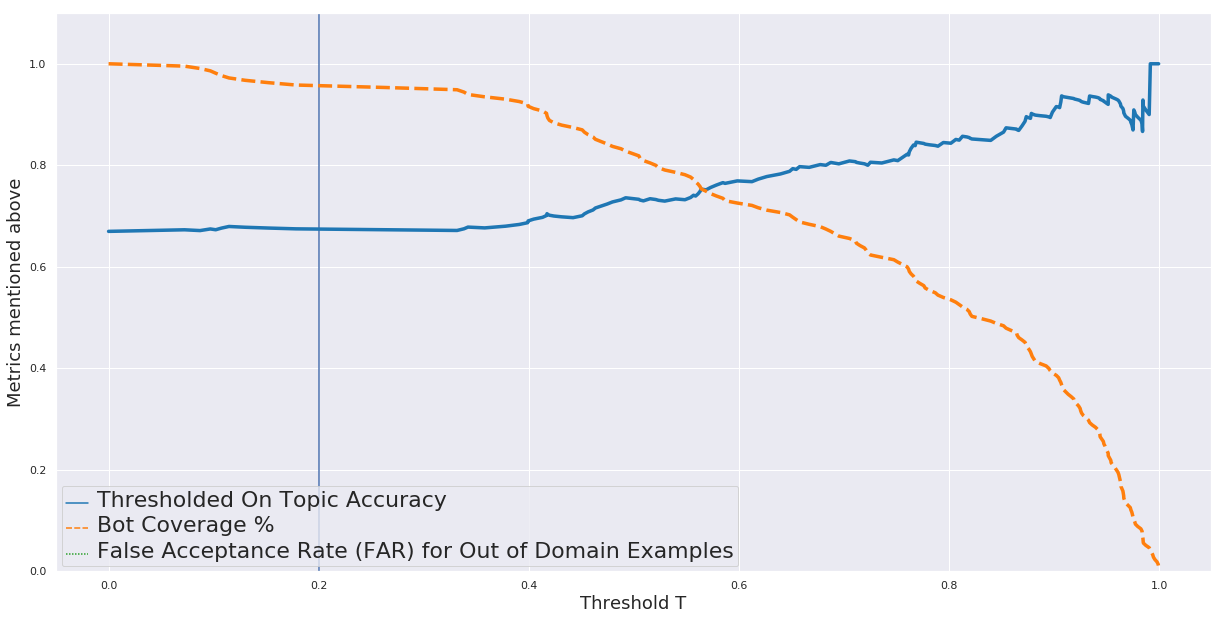

In [24]:
importlib.reload(confidence_analyzer)
# Grab a subset of the full results - ignore entities
results = full_results[['correct_intent', 'top_confidence','top_intent','utterance']]
analysis_df= confidence_analyzer.analysis(results,None)

<a id='part3.2'></a>
## 3.2 Analysis Interpretation at Confidence Level T

If a certain confidence threshold T is selected, then: 
- The on-topic accuracy for test examples which cross the threshold is ***TOA***
- The percentage of total test examples which returns confidences higher than the threshold is measured as ***Bot Coverage %***
- If out of domain examples exist, falsely accept out of domain examples as on topic examples at a rate measured by ***FAR*** (False Acceptance Rate)Perform Analysis Using Confidence Thresholds

In [25]:
analysis_df.index = np.arange(1, len(analysis_df)+1)
display(analysis_df)

,Threshold (T),Ontopic Accuracy (TOA),Bot Coverage %,Bot Coverage Counts
1,0.0,66.976744,100.000000,215 / 215
2,0.1,67.452830,98.604651,212 / 215
3,0.2,67.475728,95.813953,206 / 215
4,0.3,67.317073,95.348837,205 / 215
5,0.4,69.035533,91.627907,197 / 215
6,0.5,73.446328,82.325581,177 / 215
7,0.6,76.923077,72.558140,156 / 215
8,0.7,80.281690,66.046512,142 / 215
9,0.8,84.482759,53.953488,116 / 215
10,0.9,90.476190,39.069767,84 / 215


### Select the threshold value

By selecting a higher threshold, you can potentially bias your systems so that they are more accurate in terms of determining whether an utterance is on topic or out of domain. The default confidence threshold for Watson Assistance is 0.2.  

**Effect on accuracy**: When you select a higher threshold T, this can result in higher accuracy (TOA) because only examples with confidences greater than the threshold T are included.

**Effect on bot coverage %**: However, when you select a higher threshold T, this can also result in the virtual assistant responding to less examples.

**Deflection to human agent**: In the scenarios where the virtual assistant is setup to hand off to a human agent when it is less confident, having a higher threshold T can:  

- Improve end user experience when interacting with a virtual assistant, as it continues interaction only when its highly confident
- Result in higher costs to the customer as this can result in more deflections to the human agents 

Thus, there is a trade-off and you need to decide on a threshold value on a per customer basis.

### Examine the threshold selection on individual intents
This section allows the examination of thresholds on specific intents.

- Use `INTENT_LIST = []` to get analysis which averages across all intents
- Use `INTENT_LIST = ['intent1', 'intent2']` to examine specific intents and threshold analysis on these intents
- Use `INTENT_LIST = ['ALL_INTENTS']` to examine all intents and threshold analysis for each
- Use `INTENT_LIST = [MOST_FREQUENT_INTENT]` to get analysis on the intent with the most test examples (DEFAULT)

**False Acceptance Rate (FAR) for specific intents**  
When we calculate FAR across all intents (as in previous section) we calculate fraction of out of domain examples falsely considered on topic. When we calculate FAR for specific intents, we calculate the fraction of examples which were falsely predicted to be that specific intent.

In [26]:
importlib.reload(confidence_analyzer)

# Calculate intent with most test examples
#for label in list(test_df['intent'].value_counts().index):
#    if label != skills_util.OFFTOPIC_LABEL:
#        MOST_FREQUENT_INTENT = label 
#        break
tox_df = pd.DataFrame(workspace_data)
#
# This counts the intents and the number of times they occur
#
label_frequency = Counter(tox_df["intent"]).most_common()
frequencies = list(reversed(label_frequency))
#
# Pull out the most common and least common intents, and their utterance counts
#
min_class, min_class_len = frequencies[0]
max_class, max_class_len = frequencies[-1]
#
MOST_FREQUENT_INTENT = max_class 
#
# Specify intents of interest for analysis      
#
INTENT_LIST = [MOST_FREQUENT_INTENT]  
#
analysis_df_list = confidence_analyzer.analysis(results, INTENT_LIST)

### Threshold Analysis for Intent: site_help

,Threshold (T),Ontopic Accuracy (TOA),Bot Coverage %,Bot Coverage Counts,False Acceptance Rate (FAR)
1,0.0,73.214286,100.000000,88 / 88,100.000
2,0.1,74.074074,97.727273,86 / 88,100.000
3,0.2,73.584906,93.181818,82 / 88,90.625
4,0.3,73.076923,92.045455,81 / 88,90.625
5,0.4,77.551020,86.363636,76 / 88,84.375
6,0.5,78.260870,76.136364,67 / 88,65.625
7,0.6,81.578947,64.772727,57 / 88,59.375
8,0.7,83.333333,56.818182,50 / 88,43.750
9,0.8,89.655172,44.318182,39 / 88,31.250
10,0.9,90.476190,29.545455,26 / 88,15.625


<a id='part3.3'></a>
## 3.3 Analyze Abnormal Confidence Levels
Every test utterance is classified as a specific intent with a specific confidence by the Watson Assistant intent classifier. It is expected that model would be confident when it correctly predicts examples and not highly confident when it incorrectly predicts examples. 

But this is not always true. This can be because there are anomalies in the design. Examples that are predicted correctly with low confidence and the examples that are predicted incorrectly with high confidence are cases which need to be reviewed.

In [27]:
importlib.reload(confidence_analyzer)
correct_thresh, wrong_thresh = 0.3, 0.7
correct_with_low_conf_list, incorrect_with_high_conf_list = confidence_analyzer.abnormal_conf(
    full_results, correct_thresh, wrong_thresh)
#
if len(correct_with_low_conf_list) > 0:
    display(Markdown("#### Examples correctedly predicted with low confidence"))
    with pd.option_context('max_colwidth', 250):
        display(HTML(correct_with_low_conf_list.to_html(index=False)))
#
if len(incorrect_with_high_conf_list) > 0:
    display(Markdown("#### Examples incorrectedly predicted with high confidence"))
    with pd.option_context('max_colwidth', 250):
        display(HTML(incorrect_with_high_conf_list.to_html(index=False)))


#### Examples correctedly predicted with low confidence

correct_intent,utterance,top_confidence,top_intent
site_help,bss dashboard,0.078370,site_help
site_help,STS,0.120269,site_help
general_greeting,wassup,0.164701,general_greeting
insult,drop dead,0.139669,insult
general_thanks,TY,0.097981,general_thanks
site_help,usage by environment,0.191837,site_help


#### Examples incorrectedly predicted with high confidence

correct_intent,utterance,top1_prediction,top2_prediction,top3_prediction
person_support,how do i contact the project office?,person_csm (0.759),site_help (0.311),anything_else (0.301)
site_help,problems with feature codes,plan_info (0.868),insult (0.311),site_help (0.258)
site_help,my feature codes aren't working,plan_info (0.762),general_greeting (0.477),site_help (0.323)
site_help_training,What is the difference between an instance and a collection in Watson Discovery?,plan_info (0.85),site_help_training (0.763),person_csm (0.32)
site_help_training,where can i learn about gainsight?,site_help (0.897),site_help_training (0.56),person_csm (0.264)
tech_help,What is a skill in Watson Assistant?,site_help_training (0.9),readme (0.289),site_help (0.232)
plan_info,how can my client get credits?,site_help (0.985),site_help_training (0.261),tech_help (0.248)
plan_info,lite account,person_account_owner (0.871),site_help (0.32),plan_info (0.299)
person_support,i need ticket status,site_help (0.854),feedback (0.291),general_thanks (0.283)
person_support,no response to my ticket,site_help (0.933),general_thanks (0.283),insult (0.281)


### Actions to take when you have examples of abnormal confidence

If there are examples which are incorrectly classified with high confidence for specific intents, it may indicate an issue in the design of those specific intents because the user examples provided for that intent may be overlapping with the design of other intents.

If intent A seems to always get misclassified as intent B with high confidence or gets correctly predicted with low confidence, consider using intent conflict detection. For more information, refer to the <a href="https://cloud.ibm.com/docs/services/assistant?topic=assistant-intents#intents-resolve-conflicts" target="_blank" rel="noopener no referrer">Conflict Resolution Documentation</a>.

Also consider whether those two intents need to be two separate intents or whether they need to be merged. If they can't be merged, then consider adding more user examples which distinguish intent A specifically from intent B.

<a id='part3.4'></a>
## 3.4 Perform an Analysis Using Correlated Entities per Intent

Perform a chi square significance test for entities such as we or you for unigrams and bigrams in the previous section. For each utterance in the training data, this analysis will call the message API for entity detection on each utterance and find the most correlated entities for each intent.

In [28]:
importlib.reload(entity_analyzer)
if entities_list:
    entity_label_correlation_df = entity_analyzer.entity_label_correlation_analysis(
        full_results, entities_list)
    with pd.option_context('display.max_colwidth', 200):
        entity_label_correlation_df.index = np.arange(1, len(entity_label_correlation_df) + 1)
        display(entity_label_correlation_df)
else:
    display(Markdown("### Target workspace has no entities."))

,Intent,Correlated Entities


<a id='part3.5'></a>
## 3.5 Calculate Base Chatbot Scores

Calculate the Accuracy, precision, Recall, and F1-Scores across all intents in this Watson Assistant instance, using the results from your K-Fold testing.

In [29]:
# 
#DEBUG = True
DEBUG = False
#
# Check your testing results
#
intent_list = confMatrix_df.Actual.unique()
#
# Build dicts based on list of intents
#
true_positives = {}
true_negatives = {}
false_positives = {}
false_negatives = {}
for intent in intent_list:
    true_positives[intent] = 0
    true_negatives[intent] = 0
    false_positives[intent] = 0
    false_negatives[intent] = 0
#
# Find all true positives (TP) for each intent
#
for (index,row) in confMatrix_df.iterrows():
    #
    # If Actual = Predicted, then the Actual intent has a TP,
    # and all other intents have a TN
    #
    if (DEBUG):
        print ("Inputs ->" + row['Actual'] + " , " + row['Predicted'])
    if row['Actual'] == row['Predicted']:
        for intent in intent_list:
            if row['Actual'] != intent:
                if (DEBUG):
                    print ("  " + intent + " add TN")
                true_negatives[intent] = true_negatives[intent] + 1
            else:
                if (DEBUG):
                    print ("  " + intent + " add TP")
                true_positives[intent] = true_positives[intent] + 1
    if row['Actual'] != row['Predicted']:
        for intent in intent_list:
            if (row['Actual'] != intent) and (row['Predicted'] == intent):
                if (DEBUG):
                    print ("  " + intent + " add FP")
                false_positives[intent] = false_positives[intent] + 1
            if (row['Actual'] == intent) and (row['Predicted'] != intent):
                if (DEBUG):
                    print ("  " + intent + " add FN")
                false_negatives[intent] = false_negatives[intent] + 1                
            if (row['Actual'] != intent) and (row['Predicted'] != intent):
                if (DEBUG):
                    print ("  " + intent + " add TN")
                true_negatives[intent] = true_negatives[intent] + 1
#    
# Calculate accuracy scores
#
myAccuracy = {}
for intent in intent_list:
    myAccuracy[intent] = (true_positives[intent] + true_negatives[intent]) / (true_positives[intent] + true_negatives[intent] + false_positives[intent] + false_negatives[intent])
#
# Precision is   (TP) / (TP+FP)
#
myPrecision = {}
for intent in intent_list:
    myPrecision[intent] = true_positives[intent]  / (true_positives[intent] + false_positives[intent] )
#
# Recall is   TP / (TP + FN)
#
myRecall = {}
for intent in intent_list:
    myRecall[intent] = true_positives[intent]  / (true_positives[intent] + false_negatives[intent] )
#
# F1 Score is      2 * (Precision * Recall)/ (Precision + Recall)
#
myF1Scores = {}
for intent in intent_list:
    if ((myPrecision[intent] + myRecall[intent])==0):
        myF1Scores[intent] = "NA"
    else:
        myF1Scores[intent] = (2 * (myPrecision[intent] * myRecall[intent])) / (myPrecision[intent] + myRecall[intent])
#
# Dump table of scores for each intent
#
scoreTable = []
for intent in intent_list:
    tempAccuracy = (int(myAccuracy[intent] * 10000) ) / 100
    tempPrecision = (int(myPrecision[intent] * 10000) ) / 100
    tempRecall = (int(myRecall[intent] * 10000) ) / 100
    if myF1Scores[intent] == "NA":
        tempF1Score = "NA"
    else:
        tempF1Score = (int(myF1Scores[intent] * 10000) ) / 100
    scoreTable.append([tempAccuracy, tempPrecision, tempRecall, tempF1Score])
#
scoreTable_df = pd.DataFrame(scoreTable)
scoreTable_df.columns = ["Accuracy","Precision","Recall","F1 Score"]
scoreTable_df.index = intent_list
display(Markdown("## WATSON ASSISTANT SCORES "))
display(scoreTable_df)
#
# If COS is configured, save off your scores
#
if USE_COS:
    scoreTable_df.to_csv(Scores_file,header=True, index=True)
    #
    # Write Assistant settings out to COS
    #
    cos.upload_file(Filename=Scores_path,Bucket=credentials['BUCKET'],Key=Scores_file)
    #
    print ("Scoring results saved off to file " + Scores_file + " in results area.")

## WATSON ASSISTANT SCORES 

,Accuracy,Precision,Recall,F1 Score
site_help_training,91.62,60.00,54.54,57.14
person_support,93.02,27.27,30.00,28.57
site_help,78.13,73.21,56.16,63.56
person_csm,95.34,50.00,70.00,58.33
general_greeting,99.06,90.00,90.00,90
insult,99.53,85.71,100.00,92.3
plan_info,91.16,58.62,70.83,64.15
person_om,97.67,92.85,89.65,91.22
general_thanks,99.53,88.88,100.00,94.11
person_account_owner,96.74,71.42,76.92,74.07


Scoring results saved off to file KFold_Scores_2020-02-11_15:07:36.csv in results area.


<a id='part4'></a>
## Part 4: Summary
Congratulations! You have successfully completed the Assistant analysis evaluation. <br>
This notebook is designed to improve our dialog skill analysis in an iterative fashion. Use it to tackle one aspect of your dialog skill at a time and start over for another aspect later for continuous improvement.

###  Glossary

**True Positives (TP):** True Positive measures the number of correctly predicted positive values meaning that predicted class is the same as the actual class which is the target intent.

**True Negatives (TN):** True Negative measures the number of correctly predicted negative values meaning that the predicted class is the same as the actual class which is not the target intent.

**False Positives (FP):** False Positive measures the number of incorrectly predicted positive values meaning that the predicted class is the target intent but the actual class is not the target intent.  

**False Negatives (FN):** False Negatives measures the number of incorrectly predicted negative values meaning that the predicted class is not the target intent but the actual class is the target intent. 

**Accuracy:** Accuracy measures the ratio of corrected predicted user examples out of all user examples.   
Accuracy = (TP + TN) / (TP + TN + FP + FN)  

**Precision:** Precision measures the ratio of correctly predicted positive observations out of total predicted positive observations.   
Precision = TP / (TP + FP)  

**Recall:** Recall measures the ratio of correctly predicted positive observations out of all observations of the target intent.  
Recall = TP / (TP + FN)

**F1 Score:** F1 Score is the harmonic average of Precision and Recall.  
F1 = 2 \* (Precision \* Recall)/ (Precision + Recall)

For more information related to Watson Assistant, refer to the <a href="https://cloud.ibm.com/docs/services/assistant" target="_blank" rel="noopener no referrer">Watson Assistant Documentation</a>.